In [15]:
%matplotlib inline

In [85]:
# basic libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import math

from IPython import display
import PIL


# detectron2 utilities
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer, ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2 import model_zoo
from k12libs.utils.nb_easy import k12ai_get_top_dir

from detectron2.data.datasets import register_coco_instances

In [9]:
prefix = '/data/datasets/cv/'

# register dataset
try:
    register_coco_instances("plates", {}, f"{prefix}/plates_coco/annotations.json", f"{prefix}/plates_coco/")
except:
    pass

plates_metadata = MetadataCatalog.get("plates")
dataset_dicts = DatasetCatalog.get("plates")

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import torch, os

cfg = get_cfg()
cfg.merge_from_file(
    model_zoo.get_config_file("COCO-Detection/retinanet_R_50_FPN_3x.yaml")
)


cfg.DATASETS.TRAIN = ("plates",)
cfg.DATASETS.TEST = ()   
cfg.DATALOADER.NUM_WORKERS = 2
cfg.OUTPUT_DIR = '/data/nb_data/cv/det/plates/'

# initialize model from model zoo
cfg.MODEL.WEIGHTS = "/data/pretrained/cv/model_zoo/R-50.pkl"  
#cfg.MODEL.WEIGHTS = 'output/model_final.pth' 
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.SOLVER.BASE_LR = 0.00025

cfg.SOLVER.MAX_ITER = 10000    
cfg.SOLVER.CHECKPOINT_PERIOD = 500

# we've only one class - plate
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

WARNING [09/18 11:10:57 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/18 11:10:57 d2.data.datasets.coco]: Loaded 414 images in COCO format from /data/datasets/cv//plates_coco/annotations.json


Loading config /data/detectron2/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[09/18 11:10:58 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

WARNING [09/18 11:10:58 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[09/18 11:10:58 d2.data.datasets.coco]: Loaded 414 images in COCO format from /data/datasets/cv//plates_coco/annotations.json
[09/18 11:10:58 d2.data.build]: Removed 0 images with no usable annotations. 414 images left.
[09/18 11:10:58 d2.data.common]: Serializing 414 elements to byte tensors and concatenating them all ...
[09/18 11:10:58 d2.data.common]: Serialized dataset takes 0.16 MiB
[09/18 11:10:58 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[09/18 11:10:58 d2.data.build]: Using training sampler TrainingSampler
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: Remapping C2 weights ......
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res2.0.conv1.norm.bias            loaded from res2_0_branc

[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.conv1.norm.weight          loaded from res3_1_branch2a_bn_s        of shape (128,)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.conv1.weight               loaded from res3_1_branch2a_w           of shape (128, 512, 1, 1)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.conv2.norm.bias            loaded from res3_1_branch2b_bn_b        of shape (128,)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.conv2.norm.weight          loaded from res3_1_branch2b_bn_s        of shape (128,)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.conv2.weight               loaded from res3_1_branch2b_w           of shape (128, 128, 3, 3)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res3.1.conv3.norm.bias            loaded from res3_1_branch2c_bn_b        of shape (512,)
[09/18 11:10:59 d2.checkpoint.c2

[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv1.weight               loaded from res4_2_branch2a_w           of shape (256, 1024, 1, 1)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv2.norm.bias            loaded from res4_2_branch2b_bn_b        of shape (256,)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv2.norm.weight          loaded from res4_2_branch2b_bn_s        of shape (256,)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv2.weight               loaded from res4_2_branch2b_w           of shape (256, 256, 3, 3)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv3.norm.bias            loaded from res4_2_branch2c_bn_b        of shape (1024,)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res4.2.conv3.norm.weight          loaded from res4_2_branch2c_bn_s        of shape (1024,)
[09/18 11:10:59 d2.checkpoint

[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.conv1.weight               loaded from res5_1_branch2a_w           of shape (512, 2048, 1, 1)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.conv2.norm.bias            loaded from res5_1_branch2b_bn_b        of shape (512,)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.conv2.norm.weight          loaded from res5_1_branch2b_bn_s        of shape (512,)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.conv2.weight               loaded from res5_1_branch2b_w           of shape (512, 512, 3, 3)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.conv3.norm.bias            loaded from res5_1_branch2c_bn_b        of shape (2048,)
[09/18 11:10:59 d2.checkpoint.c2_model_loading]: backbone.bottom_up.res5.1.conv3.norm.weight          loaded from res5_1_branch2c_bn_s        of shape (2048,)
[09/18 11:10:59 d2.checkpoint

[09/18 11:10:59 d2.checkpoint.c2_model_loading]: The checkpoint state_dict contains keys that are not used by the model:
  fc1000_b
  fc1000_w
  res2_0_branch2a_b
  res2_0_branch2b_b
  res2_0_branch2c_b
  res2_0_branch1_b
  res2_1_branch2a_b
  res2_1_branch2b_b
  res2_1_branch2c_b
  res2_2_branch2a_b
  res2_2_branch2b_b
  res2_2_branch2c_b
  res3_0_branch2a_b
  res3_0_branch2b_b
  res3_0_branch2c_b
  res3_0_branch1_b
  res3_1_branch2a_b
  res3_1_branch2b_b
  res3_1_branch2c_b
  res3_2_branch2a_b
  res3_2_branch2b_b
  res3_2_branch2c_b
  res3_3_branch2a_b
  res3_3_branch2b_b
  res3_3_branch2c_b
  res4_0_branch2a_b
  res4_0_branch2b_b
  res4_0_branch2c_b
  res4_0_branch1_b
  res4_1_branch2a_b
  res4_1_branch2b_b
  res4_1_branch2c_b
  res4_2_branch2a_b
  res4_2_branch2b_b
  res4_2_branch2c_b
  res4_3_branch2a_b
  res4_3_branch2b_b
  res4_3_branch2c_b
  res4_4_branch2a_b
  res4_4_branch2b_b
  res4_4_branch2c_b
  res4_5_branch2a_b
  res4_5_branch2b_b
  res4_5_branch2c_b
  res5_0_branch2a_b


KeyboardInterrupt: 

In [112]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.8
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.4

predictor = DefaultPredictor(cfg)

In [103]:
def cv2_imshow(np_img, scale=1.0):
    np_img = np_img.clip(0, 255).astype('uint8')
    if np_img.ndim == 3:
        if np_img.shape[2] == 4:
            np_img = cv2.cvtColor(np_img, cv2.COLOR_BGRA2RGBA)
        else:
            np_img = cv2.cvtColor(np_img, cv2.COLOR_BGR2RGB)
    pil_img = PIL.Image.fromarray(np_img)
    if scale != 1.0:
        pil_img = pil_img.resize((math.ceil(scale*pil_img.width), math.ceil(scale*pil_img.height)))
    display.display(pil_img)

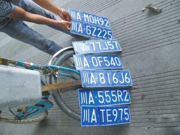

((337, 450, 3), None)

In [104]:
# img = cv2.imread('/data/datasets/cv/CCPD2019/ccpd_rotate/0500-21_15-214&373_445&554-436&554_214&467_223&373_445&460-0_0_6_5_29_24_33-132-78.jpg')
# img = cv2.imread('/data/datasets/cv/licenseplates/images/105zx.jpg')
# img = cv2.imread('/data/datasets/cv/plates_coco/JPEGImages/vodec_0206.jpg')
img = cv2.imread(os.path.join(k12ai_get_top_dir(), 'cv/assets/images/lp.jpeg'))

img.shape, cv2_imshow(img, scale=0.4)

In [115]:
outputs = predictor(img)
print(outputs, len(outputs['instances']))
print(type(outputs['instances'].pred_boxes))

{'instances': Instances(num_instances=1, image_height=337, image_width=450, fields=[pred_boxes: Boxes(tensor([[191.6146, 235.2170, 343.9289, 285.0364]], device='cuda:0')), scores: tensor([0.4286], device='cuda:0'), pred_classes: tensor([0], device='cuda:0')])} 1
<class 'detectron2.structures.boxes.Boxes'>


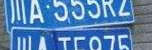

In [116]:
boxes = outputs['instances'].pred_boxes.tensor.to('cpu').numpy()[0]
x0, y0, x1, y1 = [math.ceil(z) for z in boxes]
crop_img = img[y0:y1, x0:x1]
cv2_imshow(crop_img)

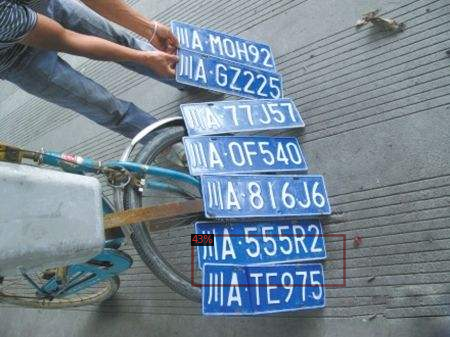

In [117]:
v = Visualizer(
    img[:, :, ::-1],
    scale=1., 
    instance_mode=ColorMode.IMAGE
)
v = v.draw_instance_predictions(outputs['instances'].to('cpu'))

result = v.get_image()
PIL.Image.fromarray(result)